In [259]:
%load_ext autoreload
%autoreload 2

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from skimage import feature
import warnings
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load data 

Useful functions:

In [20]:
from helper import *

Get training data and labels:

In [114]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
imgs = [load_image(image_dir + files[i]) for i in range(n)] 

gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]


In [115]:
N_IMAGES_TRAIN = len(files)

Extract patches:

In [116]:
# Extract patches from input images
patch_size = 10 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]
# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# 2. Features extraction

In [171]:
def extract_img_extrafeatures(file):
    """Create a feature vector of dimension w x h for each patch. """
    im = load_image(file)
    cv_patches = img_crop(feature.canny(im[:,:,0], sigma = 2), patch_size, patch_size)
    feat_vec = np.sum(cv_patches, axis =(1,2))/patch_size**2
    
    return feat_vec[:, None]

### 2.1. Canny method: edge detection

In [162]:
fc = feature.canny(imgs[0][:,:,0], sigma = 2)

Create matrix of features $62500\times 256$ (256 edge-detection pixels for each patch):

In [179]:
canny_vec = create_feature_vectors(feature.canny(imgs[0][:,:,0], sigma = 2), patch_size, patch_size)*1 # convert bool to 0 and 1
for i in range(1, n):
    fc = feature.canny(imgs[i][:,:,0])
    canny_vec = np.vstack((canny_vec, create_feature_vectors(fc, patch_size, patch_size)))*1

Create vector of features $62500\times 1$ (Number of edge-pixels for each patch):

In [200]:
cv_patches = [img_crop(feature.canny(imgs[i][:,:,0], sigma = 2), patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]
cv_patches = np.asarray([cv_patches[i][j] for i in range(len(cv_patches)) for j in range(len(cv_patches[i]))]).sum(axis = (1,2))/16**2
canny_vec = cv_patches[:, None]

### 2.2. Local Binary Pattern vector: texture classification


Joint distribution of the gray levels of P  equally spaced pixels on a circle of radius 􏰌R > 0􏰍 that form a circularly symmetric neighbor set.

In [184]:
fc=feature.local_binary_pattern(imgs[0][:,:,0],P = 10,R = 10) 

Create matrix of features $62500\times 256$ (256 texture pixels for each patch):

In [187]:
lbp_vec = create_feature_vectors(feature.local_binary_pattern(imgs[0][:,:,0], P = 10, R = 10), patch_size, patch_size)/255 # scale to (0,1)
for i in range(1, n):
    fc = feature.local_binary_pattern(imgs[i][:,:,0], P = 10, R = 10)
    lbp_vec = np.vstack((lbp_vec, create_feature_vectors(fc, patch_size, patch_size)/255))

### 2.3. Histogram of oriented gradients:

It counts occurrences of gradient orientation in localized portions of an image.

In [260]:
v, mr=feature.hog(imgs[0][:,:,0], orientations = 8, pixels_per_cell=(patch_size,patch_size), cells_per_block=(1,1), visualize=True, feature_vector=True)

Create matrix of features $62500\times 24$ (8 orientations for each color channel):

In [261]:
hog_vec = []
for j in range (3):
    hog_v = feature.hog(imgs[0][:,:,j], orientations = 8, pixels_per_cell = (patch_size, patch_size), cells_per_block = (1, 1), feature_vector = True).reshape((-1, 8))
    for i in range(1, n):
        v = feature.hog(imgs[i][:,:,j], orientations = 8, pixels_per_cell = (patch_size, patch_size), cells_per_block = (1, 1), feature_vector = True)
        hog_v = np.vstack((hog_v, v.reshape((-1, 8))))
    hog_vec.append(hog_v)

hog_vec = np.concatenate(hog_vec, axis=1)

Total data matrix for 6 color features (mean and variance for each color channel) + 256 edge features (for each pixel of 16x16 patch for gray scale image) + 256 texture features (for each pixel of 16x16 patch for gray scale image) + 24 color gradient features (histogram of 8 orientations for each color channel): $542$ features.

**Build training and testing data matrices**

In [202]:
from sklearn.model_selection import train_test_split 

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(gt_patches[i], foreground_threshold) for i in range(len(gt_patches))])

Augmented_X = np.concatenate([X, canny_vec], axis=1)

In [14]:
# # Remove features with low variance 
# from sklearn.feature_selection import VarianceThreshold 
# sel = VarianceThreshold(threshold=(0.9*(1-0.9)))

# print(Augmented_X.shape)
# print(sel.fit_transform(Augmented_X).shape)

# Augmented_X = sel.fit_transform(Augmented_X)

In [15]:
# WARN: takes a LONG TIME to run 
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features. 
# from sklearn.feature_selection import RFECV 
# from sklearn import svm
# from sklearn.feature_selection import SelectFromModel 

# # Set the estimator to linear SVM, can change 
# # estimator = SVR(kernel="linear")
# estimator = svm.LinearSVC(dual=False, class_weight="balanced")
# selector = RFECV(estimator, step=2, cv=3)
# print("selector has built")
# selector = selector.fit(Augmented_X, Y)
# print(selector.n_features_)
# print(selector.support_)


In [165]:
from sklearn import ensemble
from sklearn.feature_selection import SelectFromModel

classif = ensemble.RandomForestClassifier(100)
classif.fit(Augmented_X, Y)
model = SelectFromModel(classif, prefit=True)

In [40]:
X_new = model.transform(Augmented_X)
X_new.shape

(62500, 3)

In [203]:
X_train, X_test, Y_train, Y_test = train_test_split(Augmented_X, Y, test_size=0.3, random_state=0)

## Evaluation Metrics

Accuracy: ratio of correctly predicted observation to the total observation
$$Accuracy=\frac{TP+TN}{TP+FP+FN+TN}$$

Recall: "Of all passengers truly survived, how many did we label?"
$$Recall = \frac{TP}{TP+FN}$$

Precision: "Of all passengers labeled as survived, how many actually survived?"
$$Precision=\frac{TP}{TP + FP}$$

$F_1$ score:
$$F_1=2\cdot\frac{Recall \cdot Precision}{Recall + Precision}$$

# 3. Some classification methods:

## Logistic Regression 

In [204]:
from sklearn import linear_model
# we create an instance of the classifier and fit the data C = 1/lambda
lr_model = linear_model.LogisticRegression(class_weight="balanced", multi_class="ovr")
lr_model.fit(X_train, Y_train)

# Predict on the training set
Z_train = lr_model.predict(X_train)
Z_test = lr_model.predict(X_test)
print_eval(Y_train, Z_train, Y_test, Z_test)

/Users/virginiabordignon/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set evaluation
              precision    recall  f1-score   support

           1       0.32      0.67      0.43     26281

   micro avg       0.32      0.67      0.43     26281
   macro avg       0.32      0.67      0.43     26281
weighted avg       0.32      0.67      0.43     26281

Testing set evaluation
              precision    recall  f1-score   support

           1       0.32      0.66      0.43     11473

   micro avg       0.32      0.66      0.43     11473
   macro avg       0.32      0.66      0.43     11473
weighted avg       0.32      0.66      0.43     11473



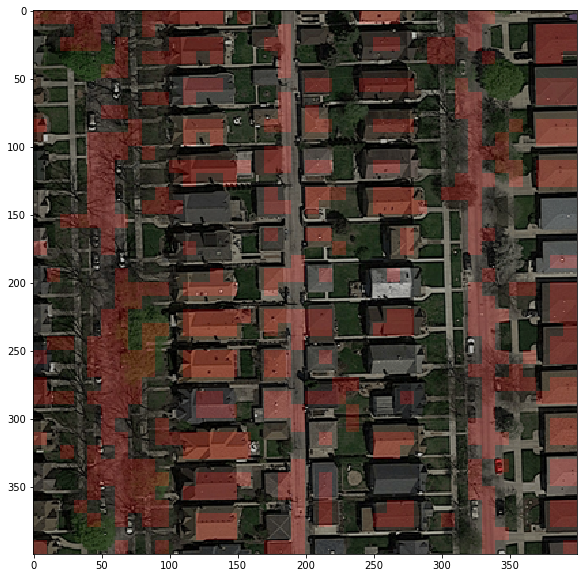

In [208]:
X_ = np.concatenate((extract_img_features(image_dir+files[0], '3d'), extract_img_extrafeatures(image_dir+files[0])), axis=1)
Xi = X_

Zi = lr_model.predict(Xi)
predicted_im = label_to_img(400, 400, patch_size, patch_size, Zi)
im = load_image(image_dir+files[0])
new_img = make_img_overlay(im, predicted_im)

predicted_im.shape
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(new_img)

## SVM

In [209]:
from sklearn import svm 

# we create an instance of the classifier and fit the data C = 1/lambda
svm_model = svm.LinearSVC(dual=False, class_weight="balanced")
svm_model.fit(X_train, Y_train)

# Predict on the training set
Z_train = svm_model.predict(X_train)
Z_test = svm_model.predict(X_test)

print_eval(Y_train, Z_train, Y_test, Z_test)

Training set evaluation
              precision    recall  f1-score   support

           1       0.32      0.67      0.43     26281

   micro avg       0.32      0.67      0.43     26281
   macro avg       0.32      0.67      0.43     26281
weighted avg       0.32      0.67      0.43     26281

Testing set evaluation
              precision    recall  f1-score   support

           1       0.32      0.66      0.43     11473

   micro avg       0.32      0.66      0.43     11473
   macro avg       0.32      0.66      0.43     11473
weighted avg       0.32      0.66      0.43     11473



## KNN

In [249]:
from sklearn import neighbors

knn_model = neighbors.KNeighborsClassifier(n_neighbors=25, n_jobs=2)
knn_model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=2, n_neighbors=25, p=2,
           weights='uniform')

In [250]:
Z_train = knn_model.predict(X_train)
Z_test = knn_model.predict(X_test)
print_eval(Y_train, Z_train, Y_test, Z_test)

Training set evaluation
              precision    recall  f1-score   support

           1       0.68      0.46      0.55     26281

   micro avg       0.68      0.46      0.55     26281
   macro avg       0.68      0.46      0.55     26281
weighted avg       0.68      0.46      0.55     26281

Testing set evaluation
              precision    recall  f1-score   support

           1       0.64      0.43      0.51     11473

   micro avg       0.64      0.43      0.51     11473
   macro avg       0.64      0.43      0.51     11473
weighted avg       0.64      0.43      0.51     11473



## Random Forest Classifier 

In [257]:
from sklearn import ensemble

classif = ensemble.RandomForestClassifier(5)
classif.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [258]:
# Predict on the training set
Z_train = svm_model.predict(X_train)
Z_test = svm_model.predict(X_test)

print_eval(Y_train, Z_train, Y_test, Z_test)

Training set evaluation
              precision    recall  f1-score   support

           1       0.32      0.67      0.43     26281

   micro avg       0.32      0.67      0.43     26281
   macro avg       0.32      0.67      0.43     26281
weighted avg       0.32      0.67      0.43     26281

Testing set evaluation
              precision    recall  f1-score   support

           1       0.32      0.66      0.43     11473

   micro avg       0.32      0.66      0.43     11473
   macro avg       0.32      0.66      0.43     11473
weighted avg       0.32      0.66      0.43     11473



# 4. Generate submission

Load test images

In [150]:
N_TEST_IMAGES = 50

In [151]:
# Loaded a set of images
root_test_dir = "test_set_images/"
test_dir = ['test_'+str(i)+'/' for i in range(1,N_TEST_IMAGES+1)]
test_images = ['test_'+str(i)+'.png' for i in range(1,N_TEST_IMAGES+1)]


In [152]:
submission_filename = 'prediction.csv'

with open(submission_filename, 'w') as f:
    f.write('id,prediction\n')
    for i in range(N_TEST_IMAGES):
        X_ = extract_img_features(root_test_dir + test_dir[i]+test_images[i], '3d')
        Xi = X_
        Zi = knn_model.predict(Xi)

        strings=[]
        count = 0
        for j in range(0, 608, patch_size):
            for k in range(0, 608, patch_size):
                strings.append("{:03d}_{}_{},{}".format(i+1, j, k, Zi[count]))
                count = count + 1


        f.writelines('{}\n'.format(s) for s in strings)


See one test image vs classification:

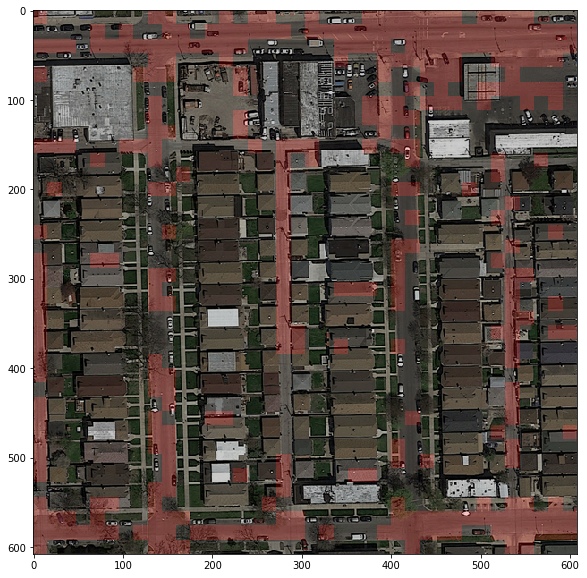

In [153]:
X_ = extract_img_features(root_test_dir + test_dir[0]+test_images[0], '3d')
Xi = X_

Zi = classif.predict(Xi)
predicted_im = label_to_img(608, 608, patch_size, patch_size, Zi)
im = load_image(root_test_dir + test_dir[0]+test_images[0])
new_img = make_img_overlay(im, predicted_im)

predicted_im.shape
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(new_img)